In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

Add src directory to the path

In [2]:
sys.path.append(os.path.abspath('../src'))

from data_utils import align_forecast_observation, calculate_metrics

Load saved data

In [3]:
import pickle

with open('../data/processed/station_data.pkl', 'rb') as f:
    station_data = pickle.load(f)

Align forecasts with observations and analyze errors for each station



Forecast error analysis for station1
Aligned data points: 326105


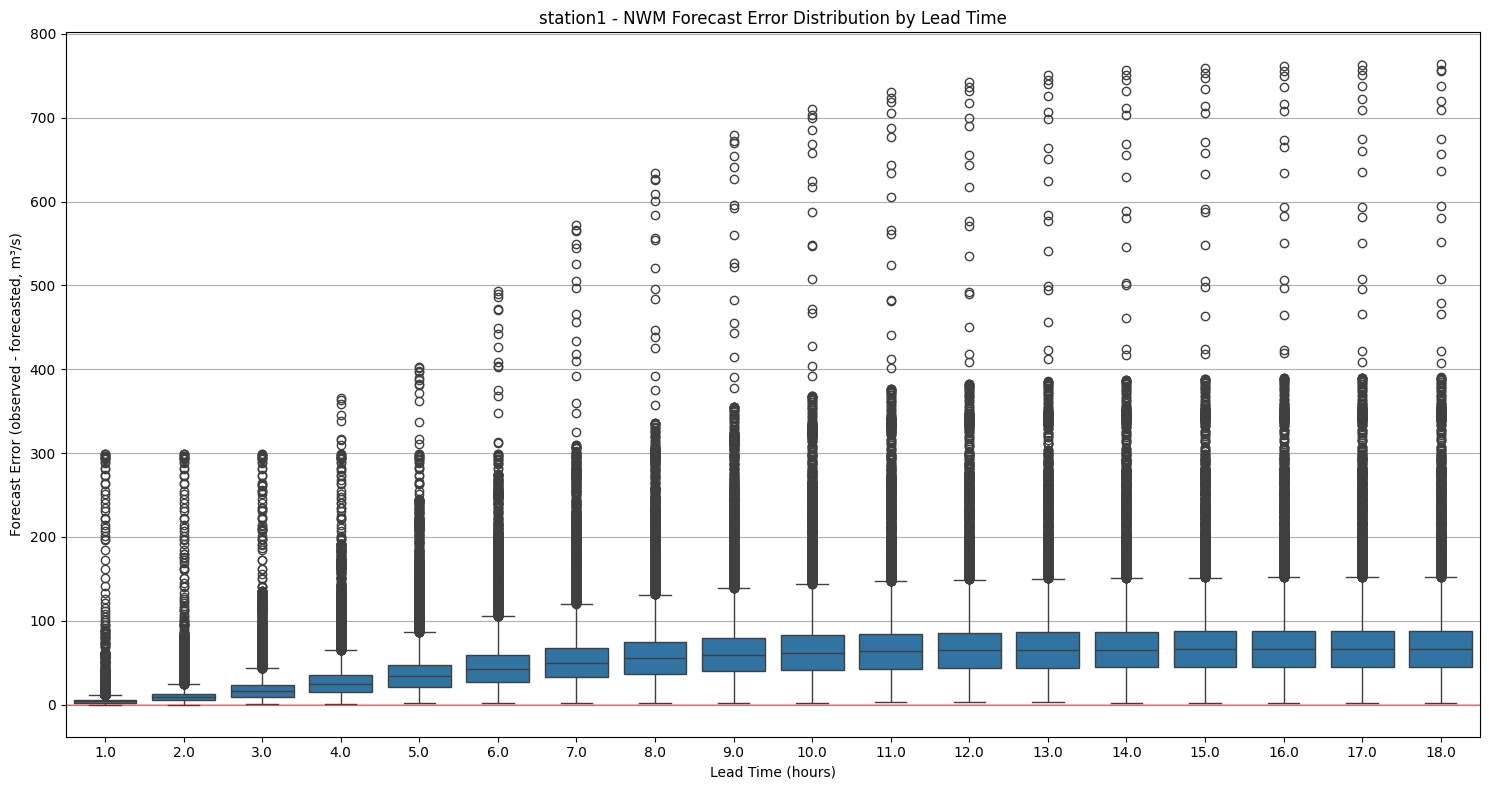

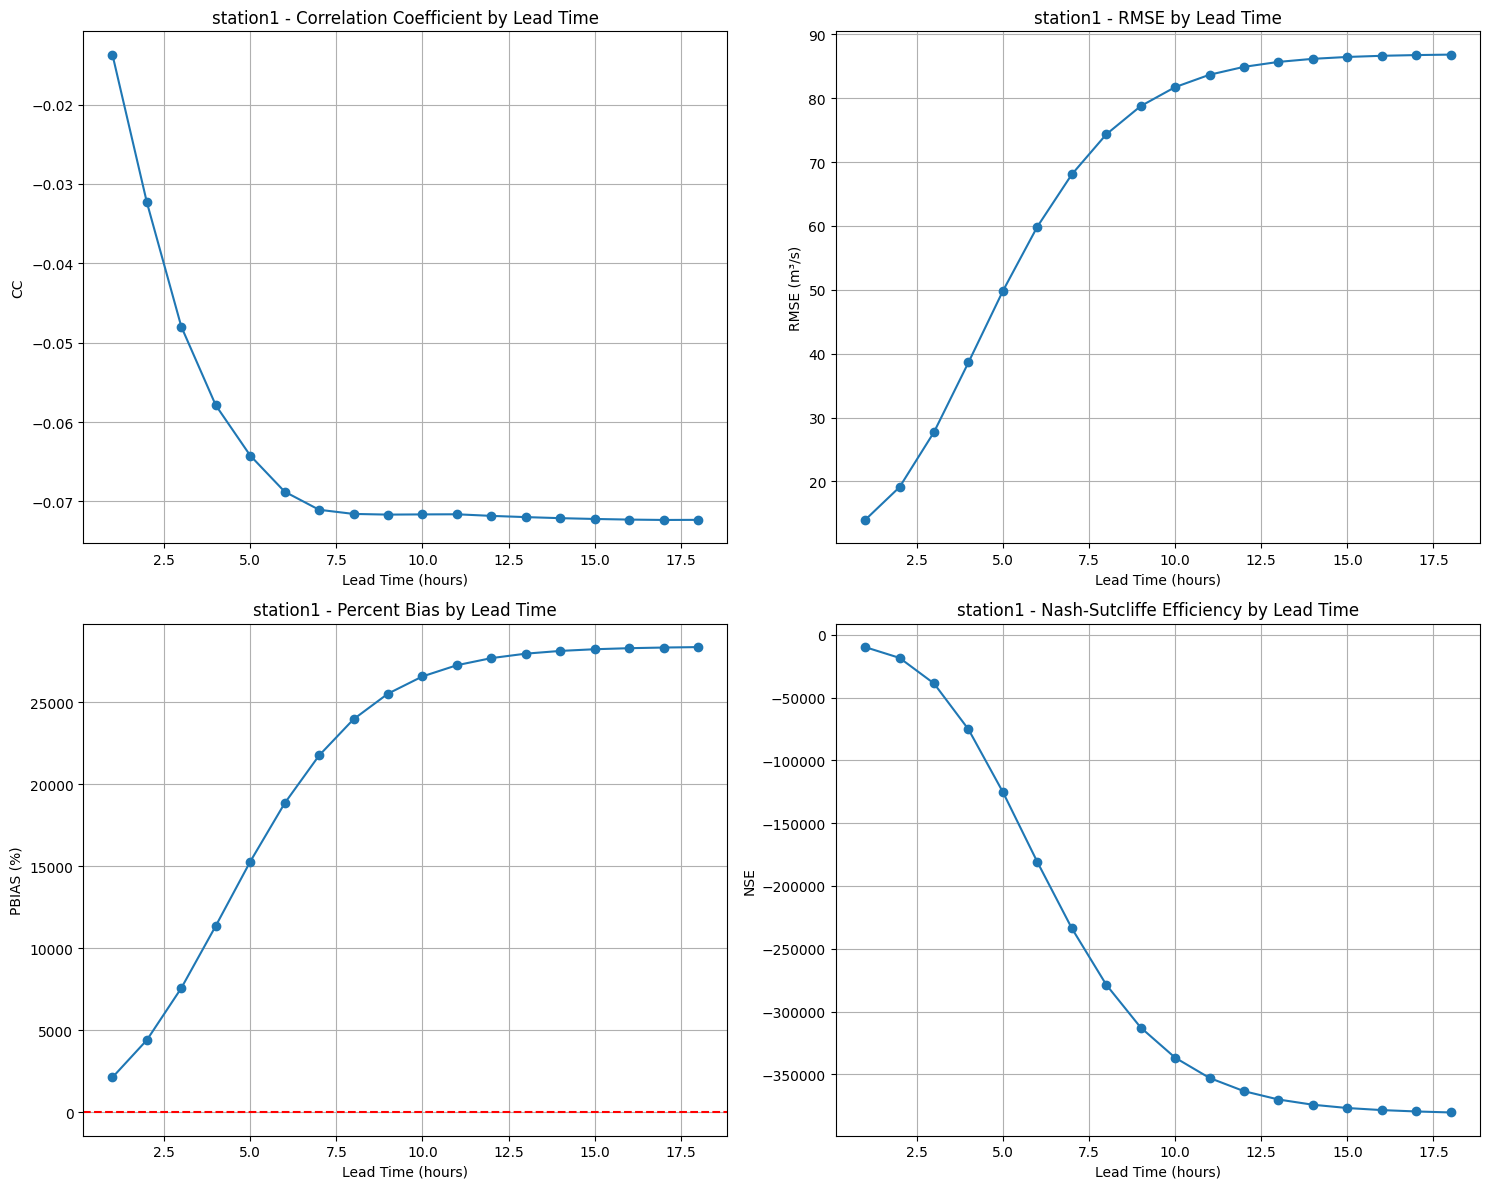

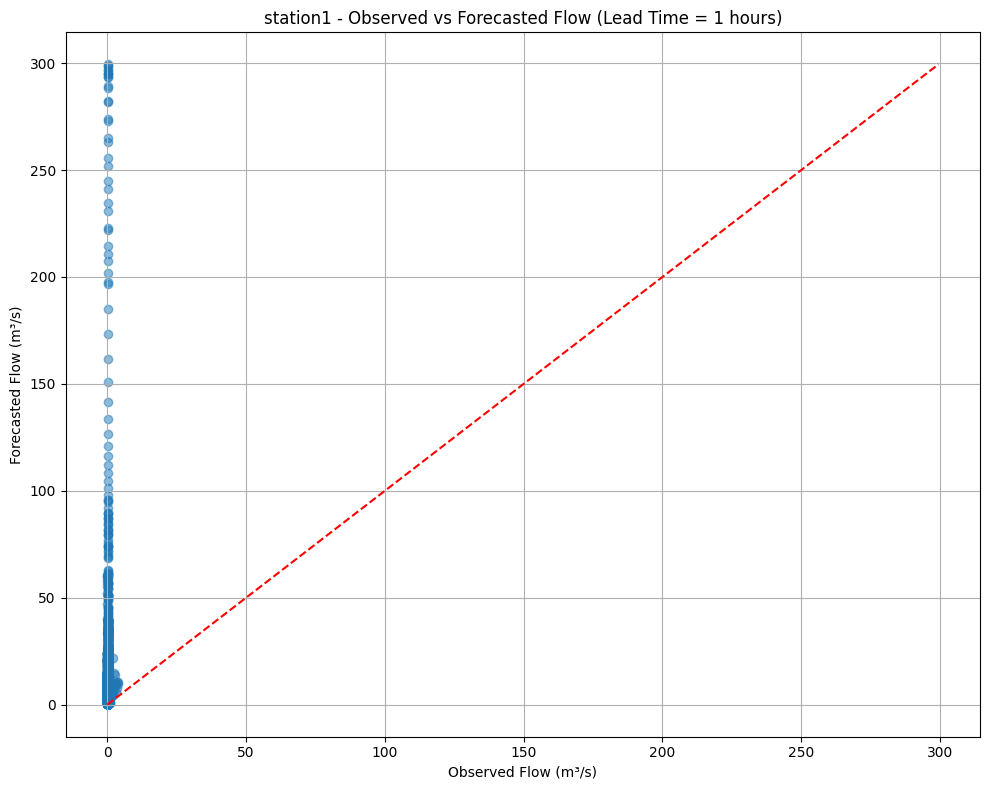

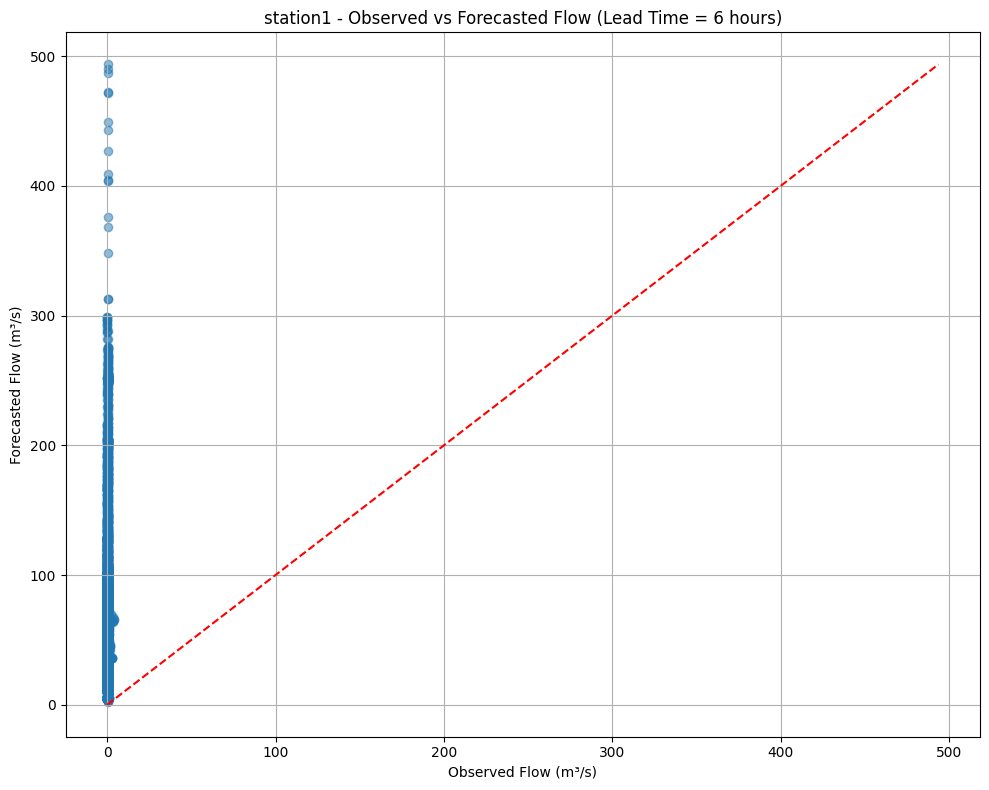

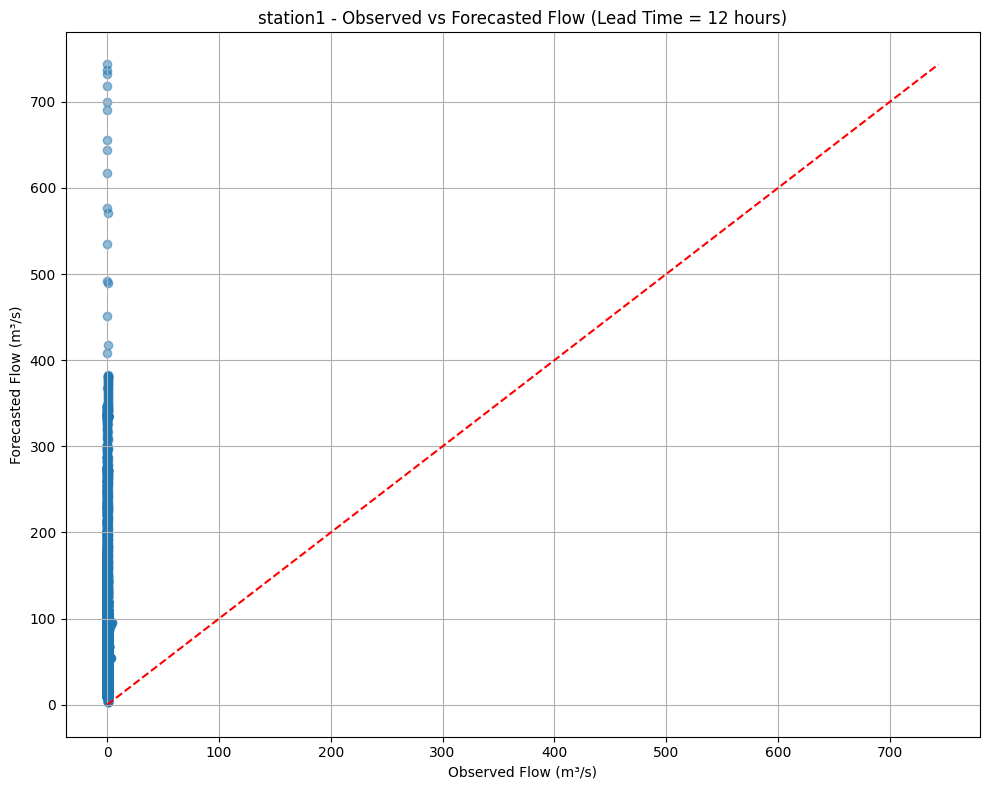

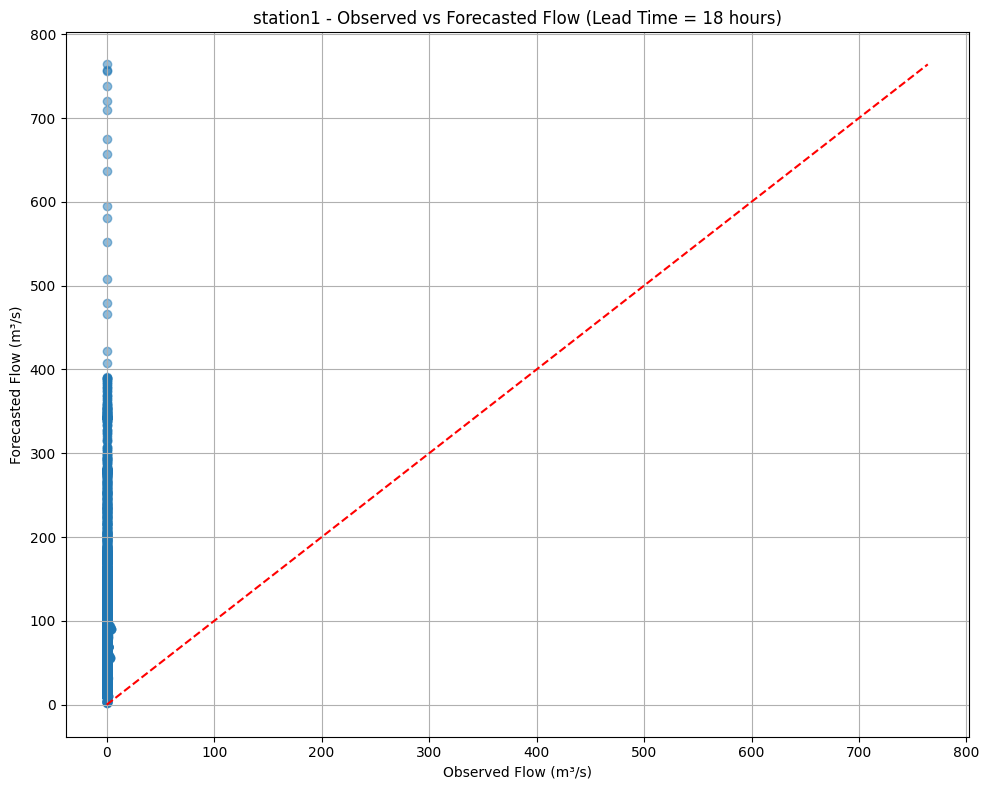

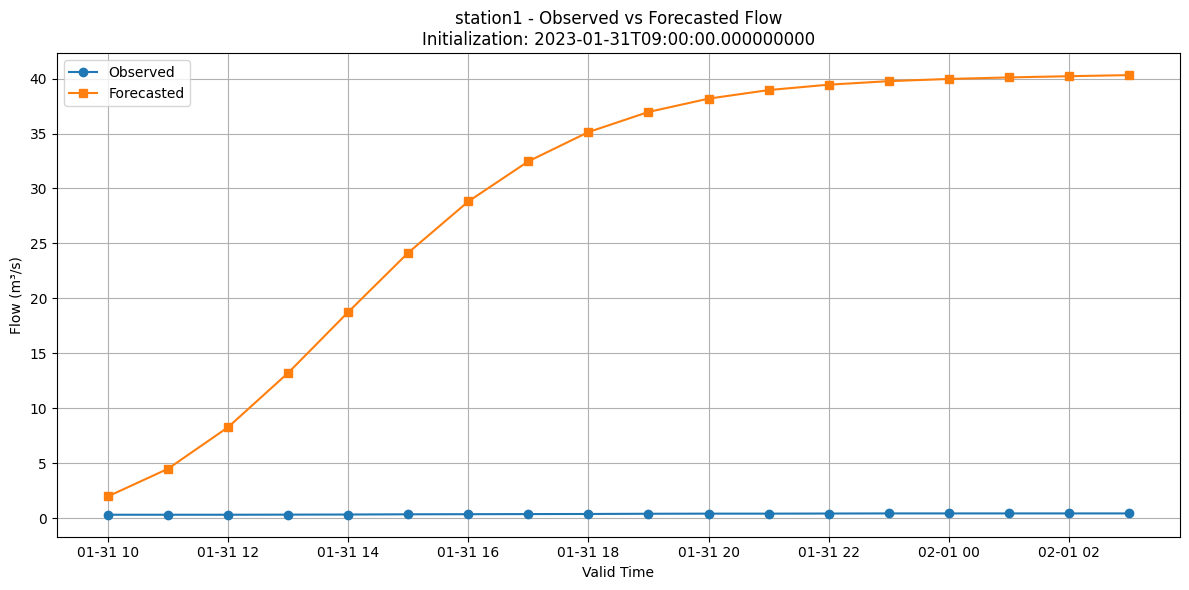

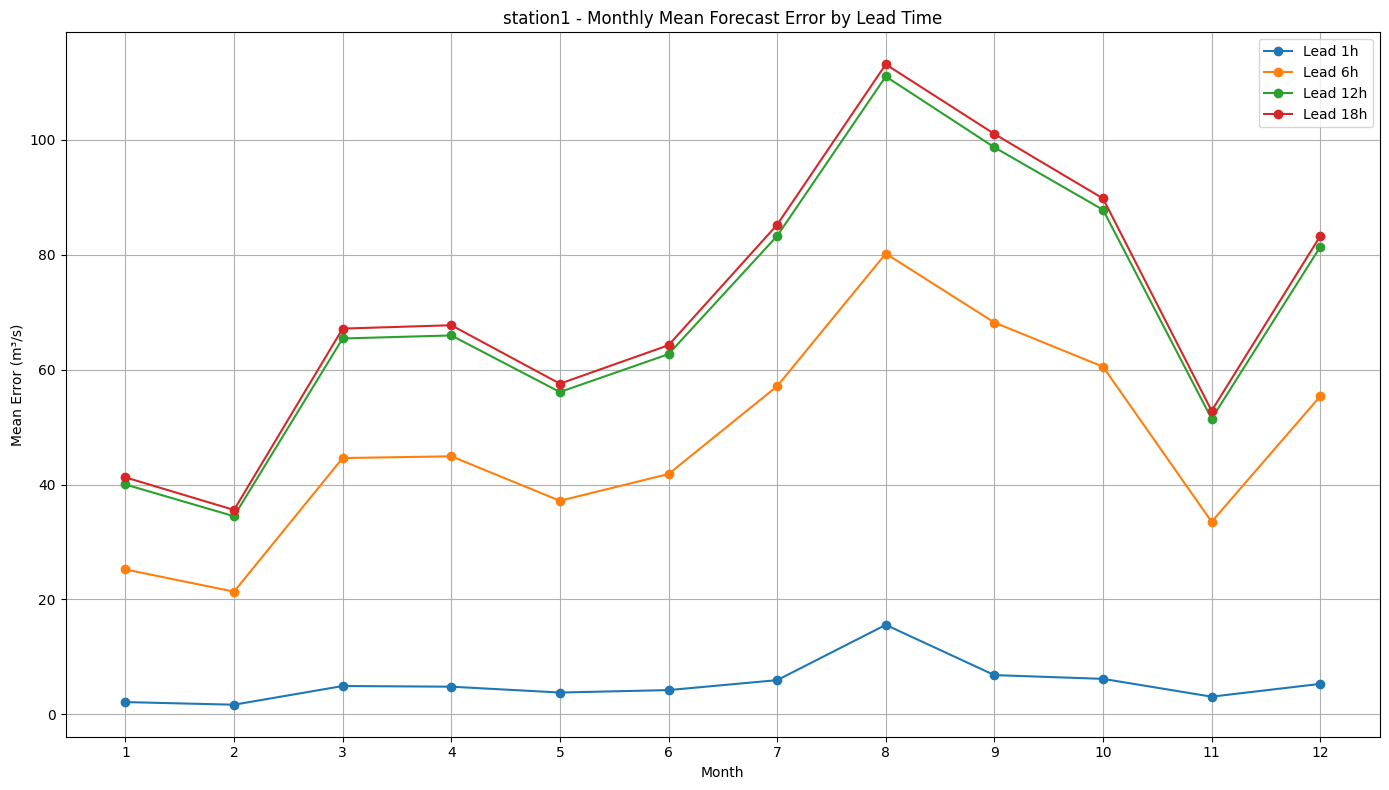

Analysis complete for station1


Forecast error analysis for station2
Aligned data points: 310247


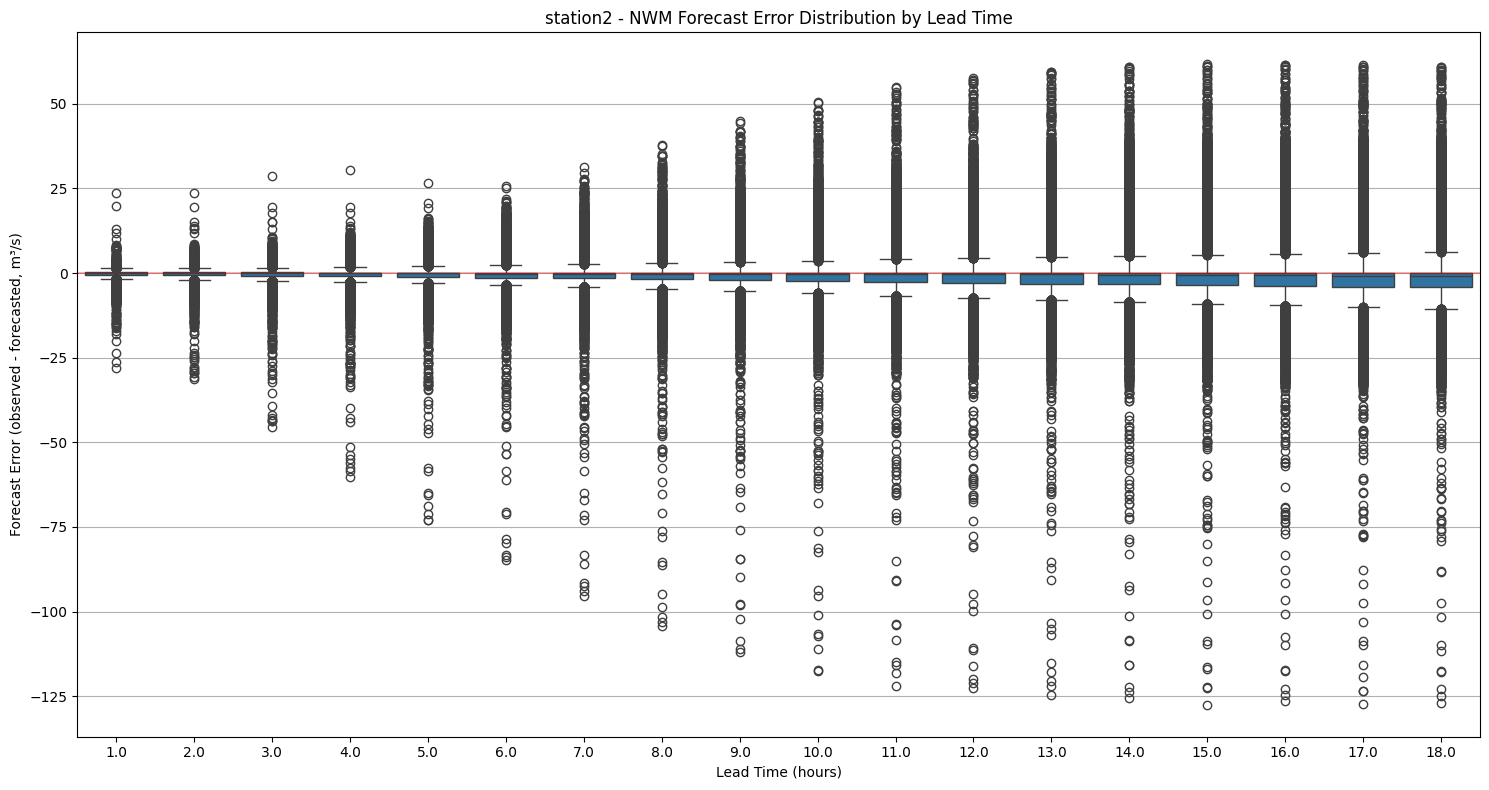

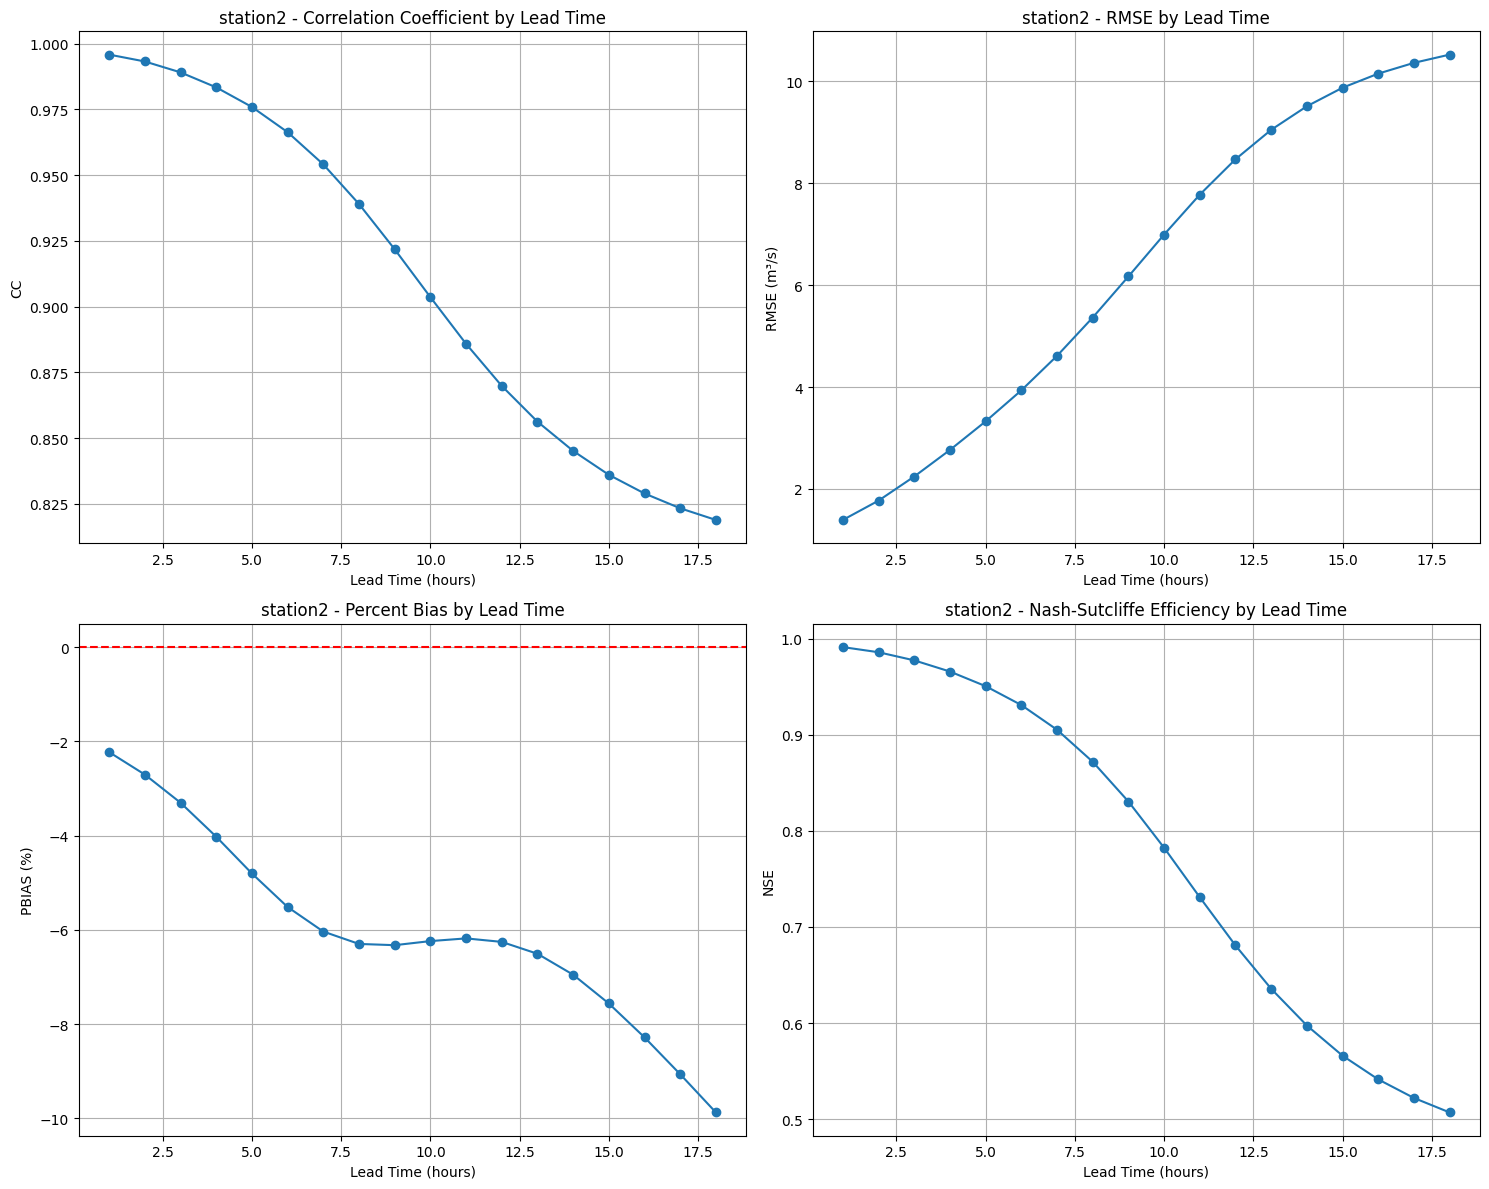

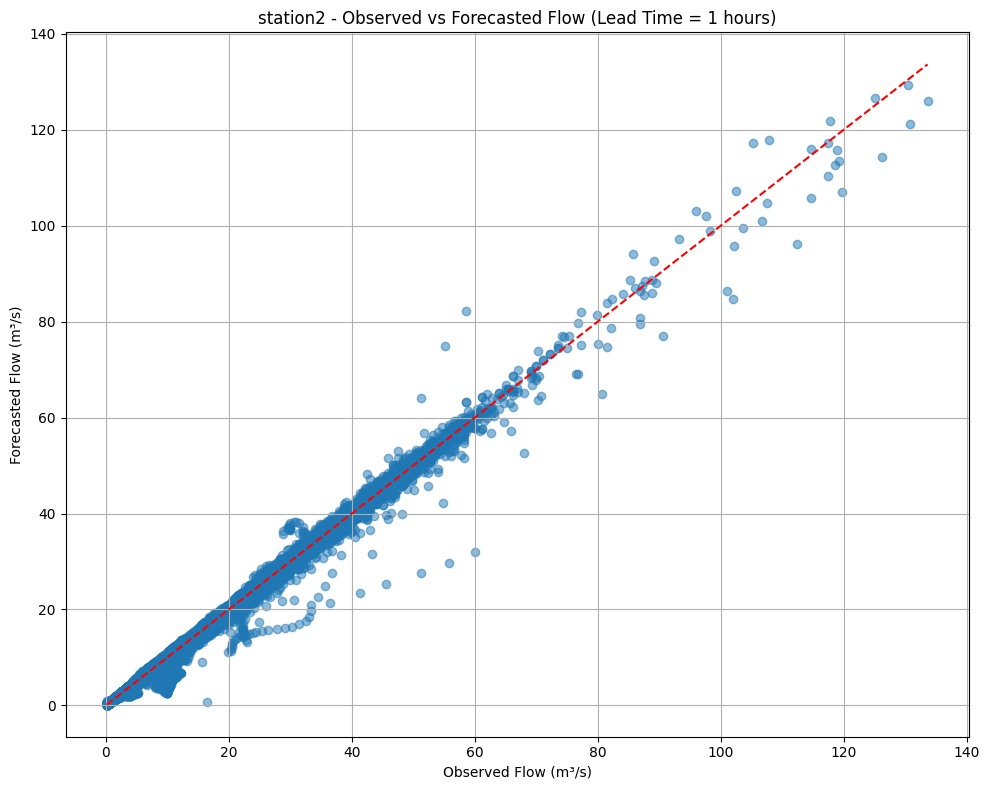

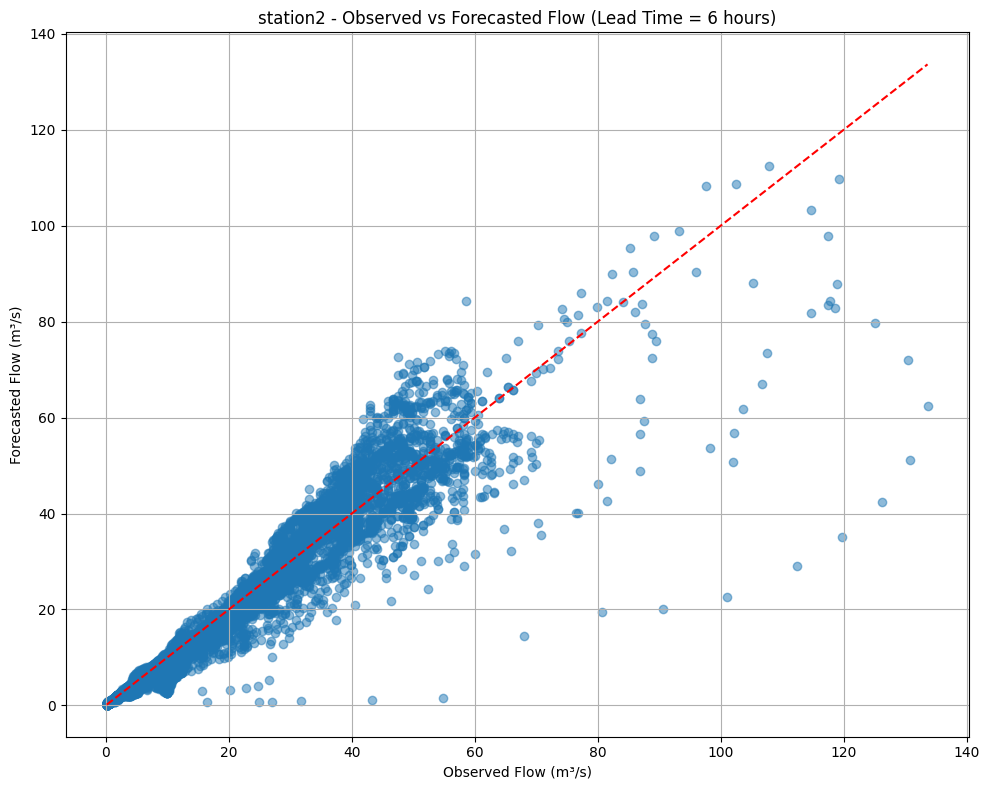

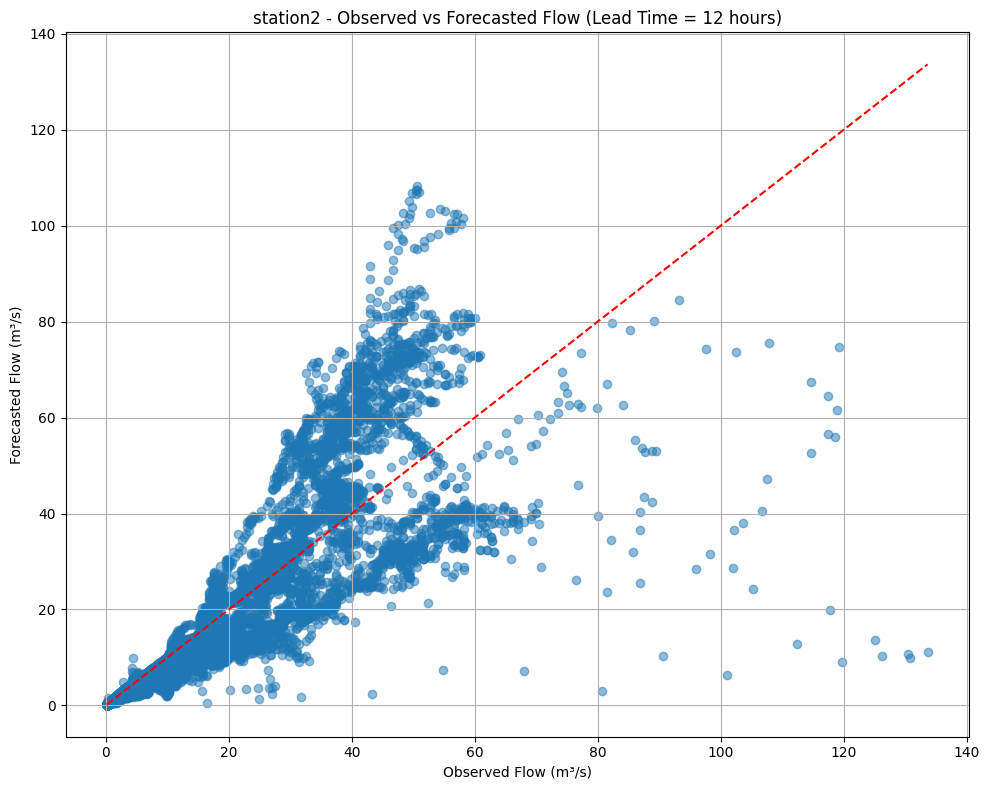

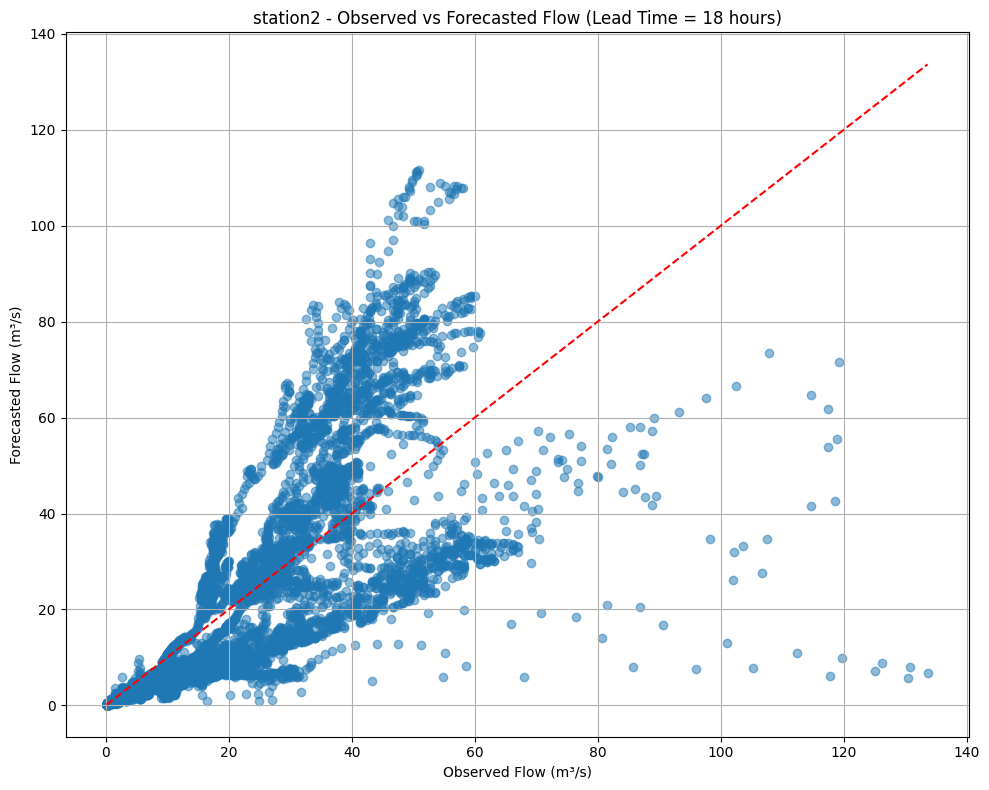

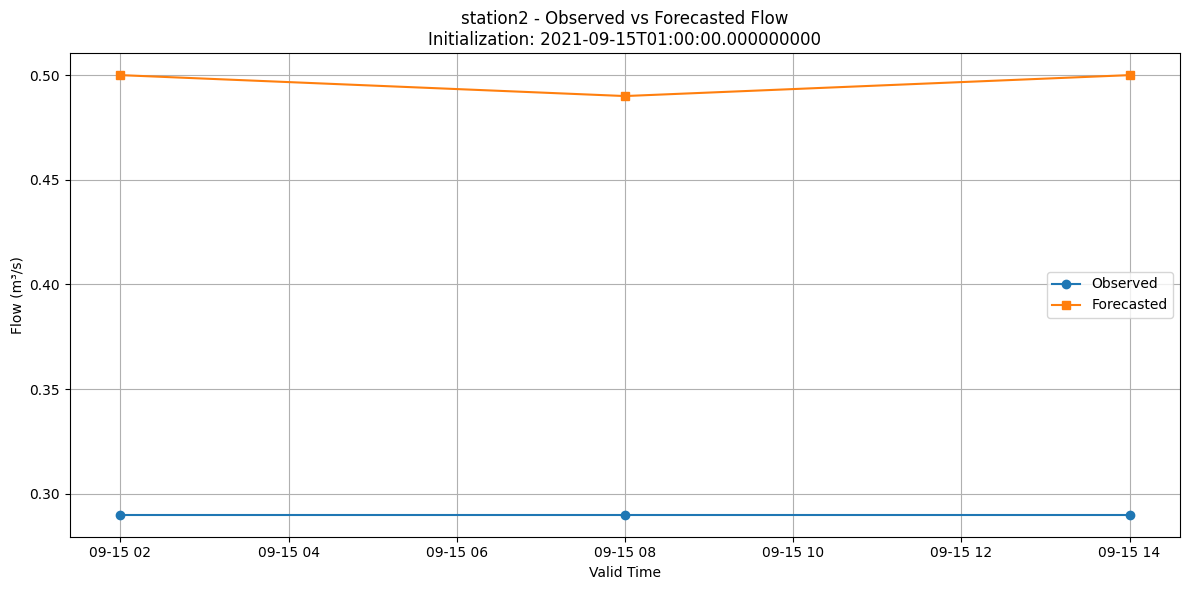

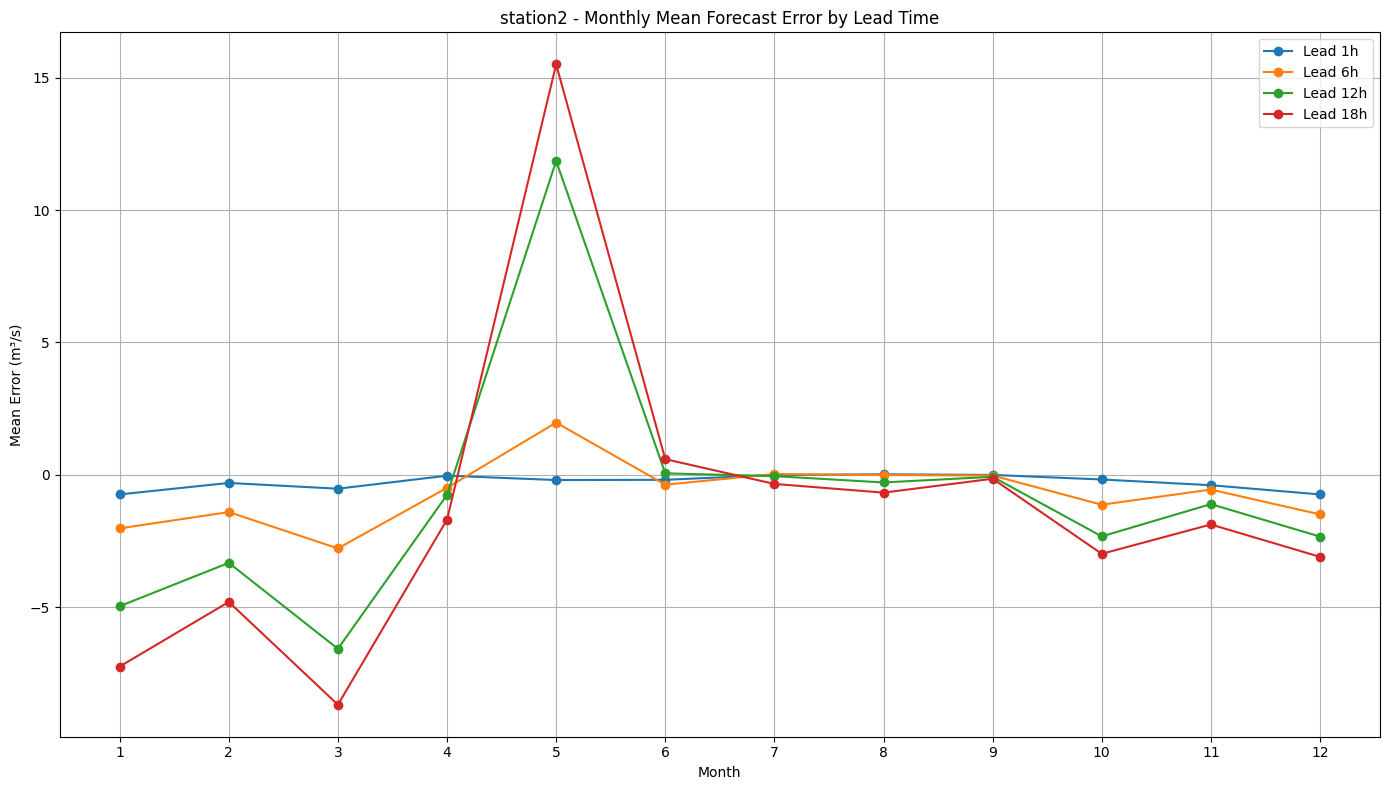

Analysis complete for station2


In [4]:
for station_name, data in station_data.items():
    usgs_data = data['usgs']
    nwm_data = data['nwm']
    
    print(f"\n\n{'='*50}")
    print(f"Forecast error analysis for {station_name}")
    print(f"{'='*50}")
        
    usgs_data.index = pd.to_datetime(usgs_data.index).tz_localize(None)
    nwm_data['model_output_valid_time'] = pd.to_datetime(nwm_data['model_output_valid_time']).dt.tz_localize(None)
    nwm_data['model_initialization_time'] = pd.to_datetime(nwm_data['model_initialization_time']).dt.tz_localize(None)
    
 # Align NWM forecasts with USGS observations
    aligned_data = align_forecast_observation(nwm_data, usgs_data)
    
    print(f"Aligned data points: {len(aligned_data)}")
    
    # Save aligned data
    aligned_data.to_csv(f"../data/processed/{station_name}_aligned_data.csv", index=False)
    
    # Calculate error statistics by lead time
    lead_times = sorted(aligned_data['lead_time'].unique())
    
    error_stats = []
    metrics_by_lead = []
    
    for lead in lead_times:
        lead_data = aligned_data[aligned_data['lead_time'] == lead]
        
        # Basic error statistics
        stats = {
            'lead_time': lead,
            'count': len(lead_data),
            'mean_error': lead_data['error'].mean(),
            'std_error': lead_data['error'].std(),
            'min_error': lead_data['error'].min(),
            'max_error': lead_data['error'].max(),
            'mean_abs_error': np.abs(lead_data['error']).mean()
        }
        error_stats.append(stats)
        
        # Calculate hydrologic metrics
        metrics = calculate_metrics(lead_data['observed_value'], lead_data['forecast_value'])
        metrics['lead_time'] = lead
        metrics_by_lead.append(metrics)
    
    # Convert to DataFrames
    error_stats_df = pd.DataFrame(error_stats)
    metrics_df = pd.DataFrame(metrics_by_lead)
    
    # Save statistics
    error_stats_df.to_csv(f"../data/processed/{station_name}_error_stats.csv", index=False)
    metrics_df.to_csv(f"../data/processed/{station_name}_metrics.csv", index=False)
    
    # Create visualizations
    
    # Box plot of errors by lead time
    plt.figure(figsize=(15, 8))
    sns.boxplot(x='lead_time', y='error', data=aligned_data)
    plt.title(f'{station_name} - NWM Forecast Error Distribution by Lead Time')
    plt.xlabel('Lead Time (hours)')
    plt.ylabel('Forecast Error (observed - forecasted, m³/s)')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"../data/figures/{station_name}_error_by_leadtime.png")
    plt.show()
    
    # Plot of error metrics by lead time
    plt.figure(figsize=(15, 12))
    
    plt.subplot(2, 2, 1)
    plt.plot(metrics_df['lead_time'], metrics_df['CC'], 'o-')
    plt.title(f'{station_name} - Correlation Coefficient by Lead Time')
    plt.xlabel('Lead Time (hours)')
    plt.ylabel('CC')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(metrics_df['lead_time'], metrics_df['RMSE'], 'o-')
    plt.title(f'{station_name} - RMSE by Lead Time')
    plt.xlabel('Lead Time (hours)')
    plt.ylabel('RMSE (m³/s)')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.plot(metrics_df['lead_time'], metrics_df['PBIAS'], 'o-')
    plt.title(f'{station_name} - Percent Bias by Lead Time')
    plt.xlabel('Lead Time (hours)')
    plt.ylabel('PBIAS (%)')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    plt.plot(metrics_df['lead_time'], metrics_df['NSE'], 'o-')
    plt.title(f'{station_name} - Nash-Sutcliffe Efficiency by Lead Time')
    plt.xlabel('Lead Time (hours)')
    plt.ylabel('NSE')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"../data/figures/{station_name}_metrics_by_leadtime.png")
    plt.show()
    
    # Scatter plot of observed vs forecasted for specific lead time
    for lead in [1, 6, 12, 18]:
        if lead not in lead_times:
            continue
            
        lead_data = aligned_data[aligned_data['lead_time'] == lead]
        
        plt.figure(figsize=(10, 8))
        plt.scatter(lead_data['observed_value'], lead_data['forecast_value'], alpha=0.5)
    
        max_val = max(lead_data['observed_value'].max(), lead_data['forecast_value'].max())
        min_val = min(lead_data['observed_value'].min(), lead_data['forecast_value'].min())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.title(f'{station_name} - Observed vs Forecasted Flow (Lead Time = {lead} hours)')
        plt.xlabel('Observed Flow (m³/s)')
        plt.ylabel('Forecasted Flow (m³/s)')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"../data/figures/{station_name}_obs_vs_forecast_lead{lead}.png")
        plt.show()   
        
    # Time series plot of observed and forecasted for specific initialization time
    sample_init = np.random.choice(aligned_data['initialization_time'].unique())
    sample_data = aligned_data[aligned_data['initialization_time'] == sample_init]
    
    plt.figure(figsize=(12, 6))
    plt.plot(sample_data['valid_time'], sample_data['observed_value'], 'o-', label='Observed')
    plt.plot(sample_data['valid_time'], sample_data['forecast_value'], 's-', label='Forecasted')
    plt.title(f'{station_name} - Observed vs Forecasted Flow\nInitialization: {sample_init}')
    plt.xlabel('Valid Time')
    plt.ylabel('Flow (m³/s)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"../data/figures/{station_name}_time_series_comparison.png")
    plt.show()
    
    # Seasonality in errors
    aligned_data['month'] = aligned_data['valid_time'].dt.month
    
    monthly_errors = aligned_data.groupby(['month', 'lead_time'])['error'].mean().reset_index()
    
    plt.figure(figsize=(14, 8))
    for lead in [1, 6, 12, 18]:
        if lead not in lead_times:
            continue
            
        lead_monthly = monthly_errors[monthly_errors['lead_time'] == lead]
        if not lead_monthly.empty:
            plt.plot(lead_monthly['month'], lead_monthly['error'], 'o-', label=f'Lead {lead}h')
    
    plt.title(f'{station_name} - Monthly Mean Forecast Error by Lead Time')
    plt.xlabel('Month')
    plt.ylabel('Mean Error (m³/s)')
    plt.xticks(range(1, 13))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../data/figures/{station_name}_monthly_errors.png")
    plt.show()
    
    print(f"Analysis complete for {station_name}")